In [1]:



import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'traffic-signs-preprocessed:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F327959%2F657000%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240309%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240309T164040Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2f9f8f6f96cbdbee7117d48df2efa33395fbed258285e46af309b9666a7e42cb4b64b2c038032378e1d8b725673640b9e2a6896490cfddfe8107f4cf1a34e599bfc6cf5cff214541c1c15f830f5d5fe82766e42be4ee85f8cbf5ffd13930f46ce5b0a7957d267a50eef5669cabb8898932fe4875779370cd4f940bd63fd1938b7ab02e4d41de9c7f95617e7658d4768b7e413940dda210fb4fe1c78ae9bf90c371b8406fb4c76d2c92d00b0fdae9c0279808870f4c0acfcdedaf55bc2232eca25068d6dafb1a80e689f74b2ba39e764e64513e85109e4d5daa658e04f5aa1cde00289a92b3c5729b2f6d8b09481d178b1725357ee53ba8094da9dee4ca103217,detect-person-on-motorbike-or-scooter:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F558735%2F1016612%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240309%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240309T164040Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D449b6f14e24419987c5748ffe387e5b7ee3facfbfdced74fdc606febb0c0e26f198b32973c2e1e65dd57a05237129c038afc57802d8f755b4d51d2511031632ea5c3f862bd62d0692a6b0c8e38929ad8db49856af27f7c3c50773928a50af46df600c7ee3afe9f9e5b7cc45aa7d28ec3495a2b570e5ef633086fb38b1545d8ee97a26600c0bcef0dff0d71a09181bb881ec278d99537dffa90e15ace0bb7b44be1310205491468714e362acaea37a5119781b6c5fd460323939de8ded686bf55faa7b137683a596aecf2404cd0f3ed74a800457865d7630785f0b857d19333addb3dd920801980eca10d0ee82f436b2187a5c28e2179a2fb5ec7ce662b083a35,helmet-detection-yolov3:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F583770%2F1054569%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240309%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240309T164040Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7f6901a0e1a801f32b63c47a69ab29254b2877eb4739550b57e7fcd5e97f142b62b21759c46dc40b5bf377bdf2d8a5125052c50593b1445c6e37b68fecde03616b90f277b208c01fd6616dff8a3e275c57e0141c273788878a0cefa37468077bfe0ef522c783282c10e29f5f7835885c3041eeb64f10bee0e0f18a315ea9084df861b1a96c38b1de75d2a124da123ad514f8fe6c52418c2e0082ad4aadb0645932925556bd2a585b18fd263742263cdb87445e125ca8f1c2766a8c59f30f34037a36dc9a56217cf92a9271be7210c02dc6851de07591d02c19f69d54aa2bbfdc0a8bd526cab0abfefe524eddd6bca945050f22de08d2409521f1c54243def0af,model3x3:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1097621%2F1845792%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240309%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240309T164040Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D58e619e046134ced2ce40c1d4ed24f2067f413043e716153ef551a6723907ba6afb2d01d6c1eba71a6a1dc3ea78873f442cbff60ff47e8fa200a4dd81a2e5e787e9b68c5bf4476b4ef17463d367bb9c43b3c89082c0bcf8c6de23c39d8b9be5adeba03d587daa942e04044386cc53b0bb290685d3cd0937b0d129adaca98733e94f98d73edfca616e540fab36de88b34cba5c3ef4b9a472b3651cccab0185d5a439e30aa78ad1a28e36dae98f0692b7b4a043fef04432a02b1a411b9151de05cea539144c6e3d3e146a7dbd60be3c8746b7aeff588b4719f6c8337fd39545ef653ac4ba22109e1debebd5b2156d60885493dc7b79b2c7f15d5ca93f9f3e5dbec,modele:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1107235%2F1860721%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240309%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240309T164040Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc63f133cfa9d7a0b4d532008c5d7ece103045d4338eed66b52542c84a1ad1bd26c81f84a14752e77f400a8264deeb5906982fdc3397c26a7885d77336c0a16d43760bf0c8fc8782a76bbd944fa06184a7505c460064f75620f7a54a82a0433a1c535c9b10ea98db6442f2b4c110ac972a42aa990dd200af111e62578e82985a73919dcab3a9692e943b7e6c1ab8e9c27a91907d3209b8a90bd6b5d5853949795d83b4b59f2d2c7e36029bec5b176e00ea7d0d60b0dcbab595219a1de12a5b47649d5bb689ad45d9b1a79654e989c4d4e1a6c8ad02df41299e0ca07d025afbcb976c7cd606ca2020eb4ee31b361601f15a93bc32b827679a17c5d3b324f9340dc,gtsrb-models-idatt-2502:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1728899%2F2861858%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240309%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240309T164040Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8473adcfcb31bd7858b79238e9dfac46c525b530194f81c89d42675a84b3345553d93173c88589d62f64f358b0d6e741e1fd12051d87d301d890f18e6f3cf1044beb1f87bce54878c30098b4744d89f5a9a7c2cd933632bb4018b809d3d2d1f38879ce71585bc59d1f576fec4ab72f56f6619d3ba3e3ba7365c65b07d697629849d284f66eccaba96a91db2fe832ce12a240ff9129c40e5e5a7cd830844f47283e3061e33f22a7ff1749f73d7426734ea240f398adc28e4cc054b138a5aa8a772c5ac17da3094905ae5041c0329bdaa8ff3b29cdf53b6c74decc7c75320b533f332a6421d65de5c3e5c38d7235574946e2cf75adaf2427bfe9c00b9f7ea1673b,traffic-violation-dataset-v3:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1765981%2F2882948%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240309%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240309T164040Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db03e8d0fd1afc0ff2e1e138e3b28c7bc577d53a47dfd7070a1b0271225855ff6a802c2f0dc4f0882d6915b3bc2b8af3be75561310ed3c353184acd0b2ad9c0ec2c9fe379e16418d59afa24edf8011baf6b60ed40fcced1c6ef2fc0ada082ff3fac5ce1f7df744f7ed85ea2326af4843d3e4352d455d03b7f10c94883efbb24c5448b0ef88187a3c33cc3f9b1bee3856d4e2c33433423a131a2b0656bb2a95dde73959047fc408a1202fbd9467d4bbb01521711101c2520d649693af9781236811f8e9f013c5f086221343cfcc44500ee094fbab6e206ced922052c685658bf6170ac13db6238e757a8f26782b0d83709f7f421b241bc564ea9c06f4de8a5737e,traffic-test:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2687174%2F4620735%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240309%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240309T164040Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D078cc8520de59866262bdf4fe07fd5bb592d77a00cabd84b80d3859854386b7d3ba083eb432cd8c385ce59abeec77a80ecf9b0085ef302698a4074668868be44e6d9af63d9a78dd9733916d25118d457c5eb3db304c8fbbd68243aca4f4cac9cb49da506319715d858026edd8a01e3dd35d43d682ace2d5d8ba3ec2029354758d92c084571faa6f744029aafca07bd0b7d80f582ee03e1a9588b7e4997e4d22b56b2383393897e48cf5afb53405bad75d9579f3a33f42321eb0725193c29958dcfc7911e79e91de379cac1944c8f6e0bb89941d98f1317aa401e521015afdba87d0bab674ed522dfda85cdddee5dd8608e1c04ed2997bac179f330cb4c0b1f6a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4471088826 bytes downloaded
Downloaded and uncompressed: traffic-signs-preprocessed
[==================================================] 369213491 bytes downloaded
Downloaded and uncompressed: detect-person-on-motorbike-or-scooter
[==================================================] 228939982 bytes downloaded
Downloaded and uncompressed: helmet-detection-yolov3
[==================================================] 36686890 bytes downloaded
Downloaded and uncompressed: model3x3
[==================================================] 74509612 bytes downloaded
Downloaded and uncompressed: modele
[==================================================] 566755435 bytes downloaded
Downloaded and uncompressed: gtsrb-models-idatt-2502
[==================================================] 1046985114 bytes downloaded
Downloaded and uncompressed: traffic-violation-dataset-v3
[==================================================] 483634859 bytes downloaded

In [2]:
# Importing required libraries
import numpy as np
import pandas as pd
import os
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pylab as pl
from PIL import Image
import pickle
from keras.models import load_model

# For Signs

In [3]:
# Reading csv file with labels' names
# Loading two columns [0, 1] into Pandas dataFrame
labels = pd.read_csv('../input/traffic-signs-preprocessed/label_names.csv')

# Showing first 5 rows from the dataFrame
print(labels.head())
print()

   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)



In [4]:
# Loading trained CNN model to use it later when classifying from 4 groups into one of 43 classes
model = load_model('../input/modele/model-3x3 (1).h5')

# Opening file for reading in binary mode
with open('../input/traffic-signs-preprocessed/mean_image_rgb.pickle', 'rb') as f:
    mean = pickle.load(f, encoding='latin1')  # dictionary type

print(mean['mean_image_rgb'].shape)  # (3, 32, 32)

(3, 32, 32)


In [5]:
# loading weights and configuration for detecting signs
weights0_path = '../input/traffic-test/sign.weights'
configuration0_path = '../input/traffic-test/sign.cfg'

In [6]:
# creating network from the config and weights and loading the sign class labels
network0 = cv2.dnn.readNetFromDarknet(configuration0_path, weights0_path)
layers_names0_all = network0.getLayerNames()
layers_names0_output = [layers_names0_all[i-1] for i in network0.getUnconnectedOutLayers()]
labels0 = open('../input/traffic-test/sign.names').read().strip().split('\n')
print(labels0)

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']


# For Just Helmet

In [7]:
# path for for helmet detection weights and config
weights1_path = '../input/helmet-detection-yolov3/yolov3-helmet.weights'
configuration1_path = '../input/helmet-detection-yolov3/yolov3-helmet.cfg'

In [8]:
# creating network from the config and weights and loading the class label
network1 = cv2.dnn.readNetFromDarknet(configuration1_path, weights1_path)
layers_names1_all = network1.getLayerNames()
layers_names1_output = [layers_names1_all[i-1] for i in network1.getUnconnectedOutLayers()]
labels1 = open('../input/helmet-detection-yolov3/helmet.names').read().strip().split('\n')
print(labels1)

['Helmet']


# For Yolov3

In [9]:
# path for weights and config for yolov3 model
weights2_path = '../input/traffic-test/model/yolov3.weights'
configuration2_path = '../input/traffic-test/model/yolov3.cfg'

In [10]:
# creating network from the config and weights and loading the 80 class labels
network2 = cv2.dnn.readNetFromDarknet(configuration2_path, weights2_path)
layers_names2_all = network2.getLayerNames()
layers_names2_output = [layers_names2_all[i-1] for i in network2.getUnconnectedOutLayers()]
labels2 = open('../input/traffic-test/yolov3.names').read().strip().split('\n')
print(labels2)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic_light', 'fire_hydrant', 'stop_sign', 'parking_meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard,', 'sports_ball', 'kite', 'baseball_bat', 'baseball_glove', 'skateboard', 'surfboard', 'tennis_racket', 'bottle', 'wine_glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot_dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell_phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy_bear', 'hair_drier', 'toothbrush']


In [29]:
# This function takes an input image and returns the output image with the bounding boxes marked for all the 3 models
def run_model(image):
    image_input = image
#     creating input image of fixed size 416x416
    blob = cv2.dnn.blobFromImage(image_input,1/255.0,(416,416),swapRB=True,crop=False)
    blob_to_show = blob[0,:,:,:].transpose(1,2,0)
    h,w = image_input.shape[:2]
    np.random.seed(42)
#     thresholds for class and nms
    probability_minimum = 0.5
    threshold = 0.3

#     This is for the sign class
    bounding_boxes0 = []
    confidences0 = []
    class_numbers0 = []
    colours0 = np.random.randint(0,255,size=(len(labels0),3),dtype='uint8')
    network0.setInput(blob)
    output_from_network0 = network0.forward(layers_names0_output)

    for result in output_from_network0:
        for detection in result:
            scores = detection[5:]
            class_current=np.argmax(scores)
            confidence_current=scores[class_current]
            if confidence_current>probability_minimum:
                box_current=detection[0:4]*np.array([w,h,w,h])
                x_center,y_center,box_width,box_height=box_current.astype('int')
                x_min=int(x_center-(box_width/2))
                y_min=int(y_center-(box_height/2))

                bounding_boxes0.append([x_min,y_min,int(box_width),int(box_height)])
                confidences0.append(float(confidence_current))
                class_numbers0.append(class_current)
    results0 = cv2.dnn.NMSBoxes(bounding_boxes0,confidences0,probability_minimum,threshold)

# Now drawing the boxes on the image
    if len(results0) > 0:
        for i in results0.flatten():
            x_min,y_min=bounding_boxes0[i][0],bounding_boxes0[i][1]
            box_width,box_height= bounding_boxes0[i][2],bounding_boxes0[i][3]

                 # Cut fragment with Traffic Sign
            c_ts = image_input[y_min:y_min+int(box_height), x_min:x_min+int(box_width), :]

            if c_ts.shape[:1] == (0,) or c_ts.shape[1:2] == (0,):
                pass
            else:
                # Getting preprocessed blob with Traffic Sign of needed shape
                blob_ts = cv2.dnn.blobFromImage(c_ts, 1 / 255.0, size=(32, 32), swapRB=True, crop=False)
                blob_ts[0] = blob_ts[0, :, :, :] - mean['mean_image_rgb']
                blob_ts = blob_ts.transpose(0, 2, 3, 1)

                # Feeding to the Keras CNN model to get predicted label among 43 classes
                scores = model.predict(blob_ts)

                # Scores is given for image with 43 numbers of predictions for each class
                # Getting only one class with maximum value
                prediction = np.argmax(scores)

                # Colour for current bounding box
#                 colour_box_current = colours0[class_numbers[i]].tolist()
                colour_box_current=[int(j) for j in colours0[class_numbers0[i]]]


                # Drawing bounding box on the original current frame
                cv2.rectangle(image_input, (x_min, y_min),
                              (x_min + box_width, y_min + box_height),
                              colour_box_current, 2)

                # Preparing text with label and confidence for current bounding box
                text_box_current = '{}: {:.4f}'.format(labels['SignName'][prediction],
                                                       confidences0[i])

                # Putting text with label and confidence on the original image
                cv2.putText(image_input, text_box_current, (x_min, y_min - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, colour_box_current, 2)

#     This is for the helmet class
    bounding_boxes1 = []
    confidences1 = []
    class_numbers1 = []
    colours1 = np.random.randint(0,255,size=(len(labels1),3),dtype='uint8')
    network1.setInput(blob)
    output_from_network1 = network1.forward(layers_names1_output)

# we will get 3 results in output_from_network0 for yolo, so iterating through all 3
    for result in output_from_network1:
#         for each result we will get multiple detections, some of them maybe duplicates
        for detection in result:
#         the first 5 values will be x,y,w,h,c and the later 80 will be the scores for the classes
            scores = detection[5:]
#     finding the class with max score
            class_current=np.argmax(scores)
            confidence_current=scores[class_current]
#         if above the threshold, add the position and w,h to bounding boxes
            if confidence_current>probability_minimum:
                box_current=detection[0:4]*np.array([w,h,w,h])
                x_center,y_center,box_width,box_height=box_current.astype('int')
                x_min=int(x_center-(box_width/2))
                y_min=int(y_center-(box_height/2))

                bounding_boxes1.append([x_min,y_min,int(box_width),int(box_height)])
                confidences1.append(float(confidence_current))
                class_numbers1.append(class_current)
# there will be multiple boxes for the same object, so we do non maximal supression with tht threshold
    results1 = cv2.dnn.NMSBoxes(bounding_boxes1,confidences1,probability_minimum,threshold)

    helmets = []
#     for each of the indivual results
    if len(results1) > 0:
        for i in results1.flatten():
            helmets.append(i);
#             get the sizes and coordinates
            x_min,y_min=bounding_boxes1[i][0],bounding_boxes1[i][1]
            box_width,box_height= bounding_boxes1[i][2],bounding_boxes1[i][3]
            colour_box_current=[int(j) for j in colours1[class_numbers1[i]]]
#             draw a rectegle and put the label with its confidence score
            cv2.rectangle(image_input,(x_min,y_min),(x_min+box_width,y_min+box_height),colour_box_current,2)
            text_box_current1='{}: {:.4f}'.format(labels1[int(class_numbers1[i])],confidences1[i])
            cv2.putText(image_input,text_box_current1,(x_min,y_min-7),cv2.FONT_HERSHEY_SIMPLEX,1,colour_box_current,3)

#     Yolov3 boxes

    bounding_boxes2 = []
    confidences2 = []
    class_numbers2 = []
    network2.setInput(blob)
    output_from_network2 = network2.forward(layers_names2_output)
    colours2 = np.random.randint(0,255,size=(len(labels2),3),dtype='uint8')

    for result in output_from_network2:
        for detection in result:
            scores = detection[5:]
            class_current=np.argmax(scores)
            confidence_current=scores[class_current]
            if confidence_current>probability_minimum:
                box_current=detection[0:4]*np.array([w,h,w,h])
                x_center,y_center,box_width,box_height=box_current.astype('int')
                x_min=int(x_center-(box_width/2))
                y_min=int(y_center-(box_height/2))

                bounding_boxes2.append([x_min,y_min,int(box_width),int(box_height)])
                confidences2.append(float(confidence_current))
                class_numbers2.append(class_current)


    results2 = cv2.dnn.NMSBoxes(bounding_boxes2,confidences2,probability_minimum,threshold)
    print("Confidence :", confidences2)
    motorbikes = []

    if len(results2) > 0:
        for i in results2.flatten():
            x_min,y_min=bounding_boxes2[i][0],bounding_boxes2[i][1]
            if class_numbers2[i] == 3:
                motorbikes.append(i)

    best_bikes = set()
    for helmet in helmets:
        _min = float("inf")
        best_bike = -1
        for bike in motorbikes:
            xh, yh = bounding_boxes1[helmet][0], bounding_boxes1[helmet][1]
            xb, yb = bounding_boxes2[bike][0], bounding_boxes2[bike][1]
            distance = math.sqrt((xh - xb) ** 2 + (yh - yb) ** 2)
            if distance < _min:
                _min = distance
                best_bike = bike
        best_bikes.add(best_bike)
        print("For Helmet at ", bounding_boxes1[helmet][0], bounding_boxes1[helmet][1], "Bike is ", bounding_boxes2[best_bike][0], bounding_boxes2[best_bike][0])

    if len(results2) > 0:
        for i in results2.flatten():
            x_min,y_min=bounding_boxes2[i][0],bounding_boxes2[i][1]
            box_width,box_height= bounding_boxes2[i][2],bounding_boxes2[i][3]
            colour_box_current=[int(j) for j in colours2[class_numbers2[i]]]

            output_text = labels2[int(class_numbers2[i])]
            if i not in best_bikes and output_text == "motorbike":
                output_text = "violation"
                colour_box_current = (255, 0, 0)
            text_box_current2='{}: {:.4f}'.format(output_text,confidences2[i])

            cv2.rectangle(image_input,(x_min,y_min),(x_min+box_width,y_min+box_height),colour_box_current,2)
            cv2.putText(image_input,text_box_current2,(x_min,y_min-7),cv2.FONT_HERSHEY_SIMPLEX,1,colour_box_current,3)

    return image_input

In [30]:
# function takes filename and starting and ending frame and applies the model on those frames and saves output video
def generate_output_video(filename, start_frame = 0, end_frame = -1):
    if os.path.exists("/kaggle/working/" + filename):
        os.remove("/kaggle/working/" + filename)
    # capture the video
    cap = cv2.VideoCapture("../input/traffic-test/" + filename)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    out_mp4 = cv2.VideoWriter(filename,cv2.VideoWriter_fourcc(*'XVID'), 10, (frame_width,frame_height))
    # check if capture was successful
    if not cap.isOpened():
        print("Could not open!")
    else:
        print("Video read successful!")
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print('Total frames: ' + str(total_frames))

    limit = total_frames
    if end_frame != -1:
        limit = end_frame
    image = None
    for i in range(limit):
        success = cap.grab()
#         get a single frame
        ret, image = cap.retrieve()
        if i >= start_frame:
            %matplotlib inline
#             run model on the single frame
            output_image = run_model(image)
#     write the output back
            out_mp4.write(output_image)
            if i % 10 == 0:
                print("Frame " + str(i) + " Processed")
    out_mp4.release()


In [31]:
filename = "bike-test.mp4"
print("../input/traffic-test/" + filename)
# generate_output_video(filename, 0, 100)

../input/traffic-test/bike-test.mp4


Confidence Score: 0.0
Confidence : [0.5563217401504517, 0.5377809405326843, 0.988766074180603, 0.7327487468719482, 0.6007643342018127, 0.6803539395332336, 0.9957462549209595, 0.7391719222068787, 0.9944350123405457, 0.8756116032600403, 0.8835214376449585, 0.9421424865722656, 0.5065993070602417, 0.9982399940490723, 0.8245972990989685, 0.9977803230285645, 0.9257016181945801, 0.9882556200027466, 0.9959341287612915, 0.8668298721313477, 0.6238970756530762, 0.6334776282310486, 0.6414567828178406, 0.8688180446624756, 0.7858563661575317, 0.8216833472251892, 0.8098832368850708, 0.5436496734619141, 0.8638105988502502]
For Helmet at  105 38 Bike is  0 0


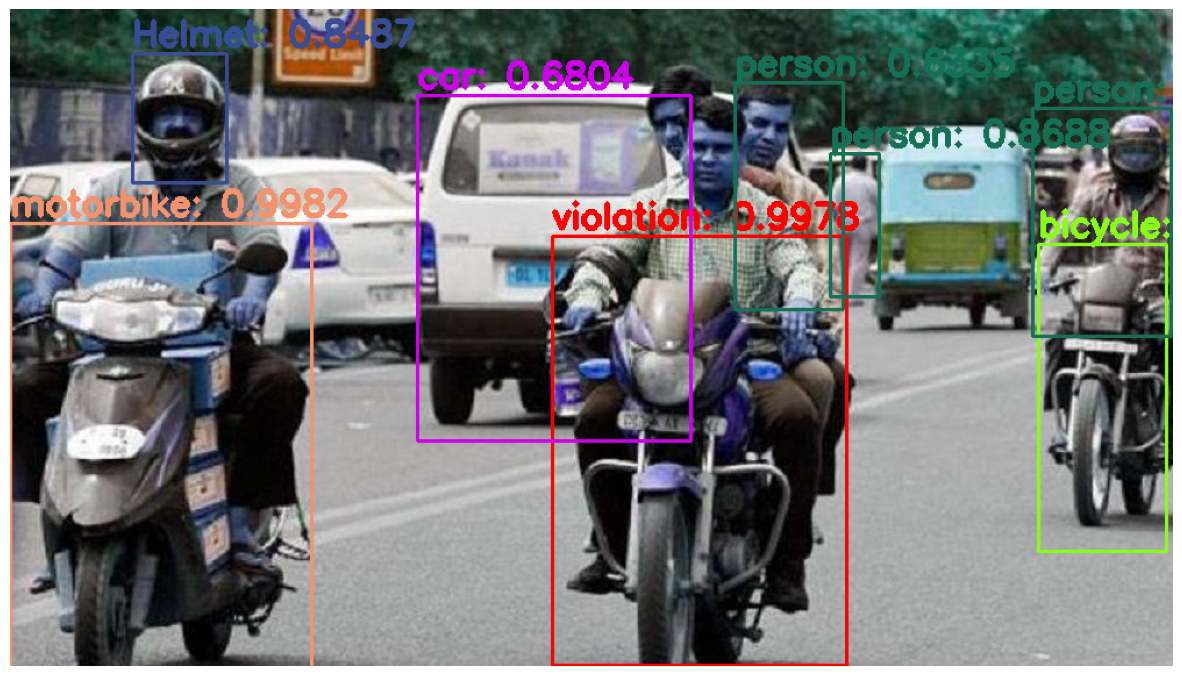

In [32]:
img0 = cv2.imread("../input/traffic-test/bike12.jpeg")
output_image = run_model(img0)

%matplotlib inline
plt.figure(figsize = (15,15))
plt.axis('off')
plt.imshow(output_image)

Confidence Score: 0.0
Confidence : [0.9821441769599915, 0.9791954159736633, 0.9995664358139038, 0.9990173578262329]


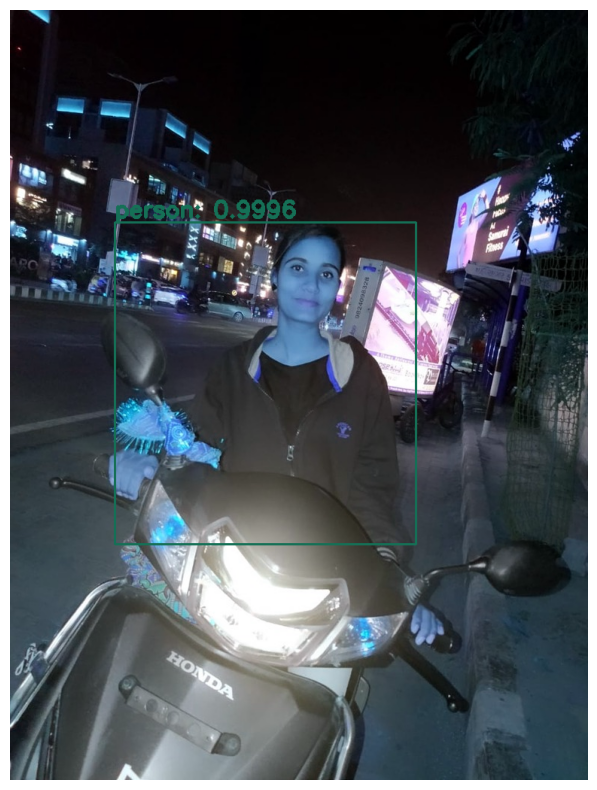

In [33]:
img0 = cv2.imread("/content/7A8606FA-EC82-4A21-B88F-21071FAA69A8_1_105_c.jpeg.jpg")
output_image = run_model(img0)

%matplotlib inline
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(output_image)

Confidence Score: 0.0
Confidence : [0.6860180497169495, 0.9406118392944336, 0.5059303045272827, 0.5806861519813538, 0.7973000407218933, 0.8794564008712769, 0.6502442955970764, 0.83370441198349, 0.7276537418365479, 0.969306230545044, 0.8485522270202637, 0.9601150751113892, 0.736116349697113, 0.8066784143447876]


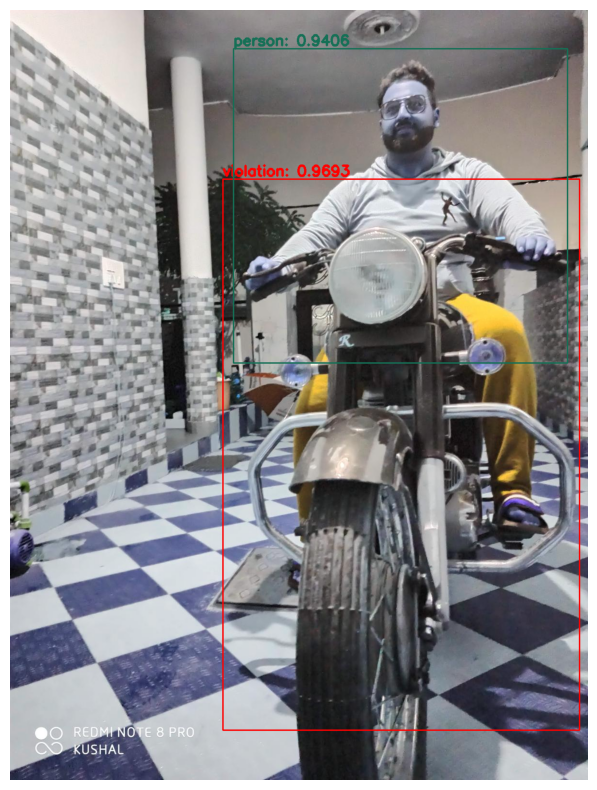

In [36]:
img2 = cv2.imread("/WhatsApp Image 2024-03-05 at 12.01.32_ee41dc76.jpg")
output_image = run_model(img2)
%matplotlib inline
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(output_image)

Confidence Score: 0.0
Confidence : [0.9421409368515015, 0.9721097350120544, 0.9927719831466675, 0.5016371607780457, 0.990580141544342, 0.9905806183815002, 0.8375993371009827, 0.5273399949073792, 0.940253496170044, 0.7777372598648071, 0.6128402352333069, 0.8966113924980164, 0.5364593863487244, 0.8246546983718872, 0.7492124438285828, 0.8137387037277222, 0.5245226621627808, 0.6154472231864929, 0.7469390034675598, 0.5704401135444641, 0.6001933217048645, 0.5942701101303101]
For Helmet at  420 448 Bike is  370 370


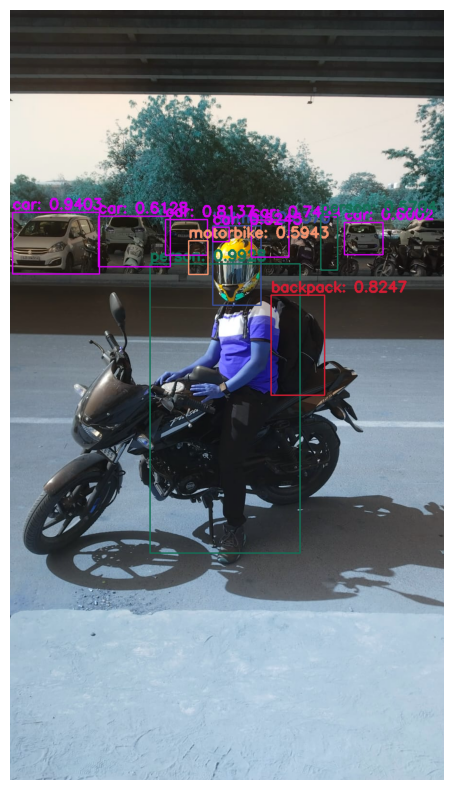

In [39]:
img2 = cv2.imread("/WhatsApp Image 2024-03-09 at 13.27.05_c643b487.jpg")
output_image = run_model(img2)
%matplotlib inline
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(output_image)

In [37]:
import cv2
import random

def capture_random_frames(video_path, output_folder, num_frames):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        print("Error: Unable to read video.")
        return

    print(f"Total frames in the video: {total_frames}")

    # Ensure the output folder exists
    import os
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Calculate random frame indices
    random_frames = random.sample(range(total_frames), num_frames)

    for frame_number in random_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if ret:
            output_path = os.path.join(output_folder, f"frame_{frame_number}.jpg")
            cv2.imwrite(output_path, frame)
            print(f"Saved frame {frame_number} at {output_path}")

    cap.release()

if __name__ == "__main__":
    # Replace 'input_video.mp4' with the path to your video file
    input_video_path = '/WIN_20240308_17_07_31_Pro.mp4'

    # Replace 'output_frames' with the folder where you want to save the frames
    output_frames_folder = 'output_frames'

    # Specify the number of random frames you want to capture
    num_random_frames = 5

    capture_random_frames(input_video_path, output_frames_folder, num_random_frames)


Total frames in the video: 489
Saved frame 308 at output_frames/frame_308.jpg
Saved frame 130 at output_frames/frame_130.jpg
Saved frame 383 at output_frames/frame_383.jpg
Saved frame 85 at output_frames/frame_85.jpg
Saved frame 477 at output_frames/frame_477.jpg


Confidence Score: 0.0
Confidence : [0.8680194616317749, 0.9670054912567139]
For Helmet at  726 200 Bike is  626 626


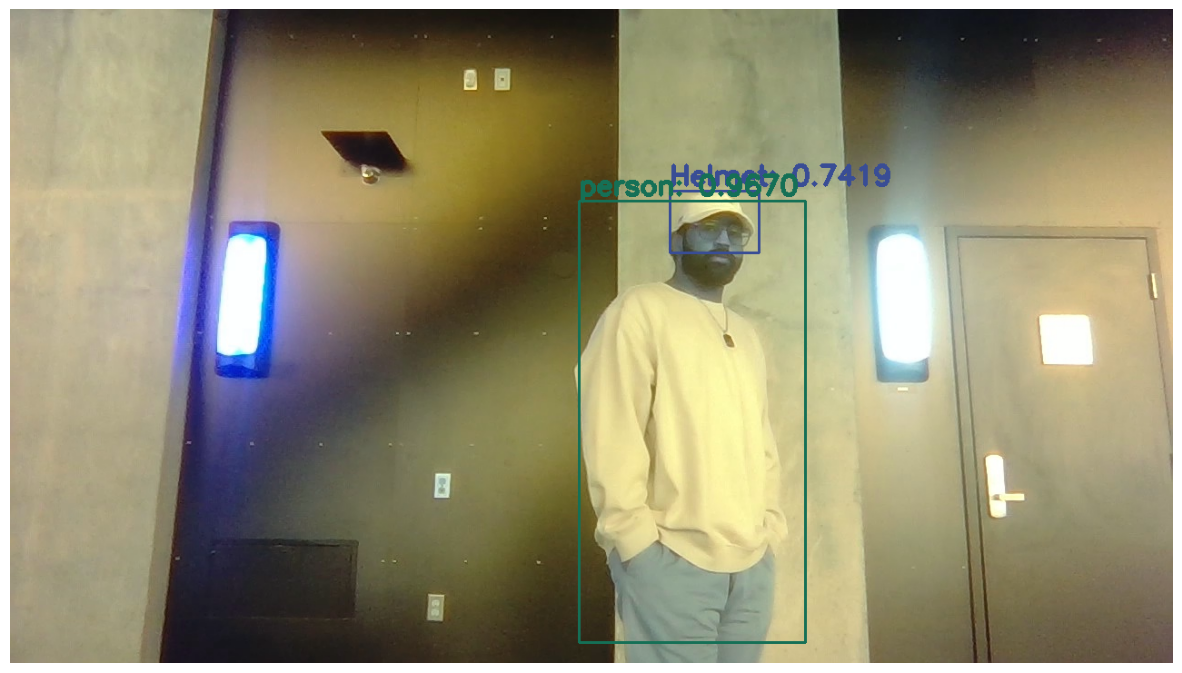

In [38]:
img0 = cv2.imread("output_frames/frame_477.jpg")
output_image = run_model(img0)

%matplotlib inline
plt.figure(figsize = (15,15))
plt.axis('off')
plt.imshow(output_image)

In [47]:
import cv2
import dlib
for i in labels2:
  if(i == "person" or i == "violation" ) :
    if ("violation" >= "0.7"):

      def face_verification(image_path_1, image_path_2):
          # Load pre-trained face detector from dlib
          face_detector = dlib.get_frontal_face_detector()

          # Load images
          image_1 = cv2.imread(image_path_1)
          image_2 = cv2.imread(image_path_2)

          # Convert images to grayscale
          gray_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
          gray_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

          # Detect faces in the images
          faces_1 = face_detector(gray_1)
          faces_2 = face_detector(gray_2)

          if len(faces_1) == 0 or len(faces_2) == 0:
              return

          # Get the first face in each image
          face_1 = faces_1[0]
          face_2 = faces_2[0]

          # Extract face embeddings using a face recognition model (e.g., FaceNet)
          # You need to implement this part or use a pre-trained model

          # Compare the embeddings for verification
          # You need to implement this part based on the face recognition model

          # For simplicity, let's assume faces are verified if they are in the same location
          verification_threshold = 650
          distance = dlib.rectangle.left(face_1) - dlib.rectangle.left(face_2)

          if abs(distance) < verification_threshold:
              name = os.path.splitext(os.path.basename(image_path_2))[0]
              print("Faces are verified in Database. Fine Generated. Notification sent to :", name)
              return True
          else:
              print("Faces are not verified. Checking Database again.")
              return False

      # Example usage
      image_path_1 = "output_frames/frame_477.jpg"
      dataset = "/dataset_folder"
      for filename in os.listdir(dataset):
        if filename.endswith(".jpg"):
          image_path_2 = os.path.join(dataset, filename)
          result = face_verification(image_path_1, image_path_2)

Faces are not verified. Checking Database again.
Faces are verified in Database. Fine Generated. Notification sent to : Kushal


In [48]:
import cv2
import random

def capture_random_frames(video_path, output_folder, num_frames):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        print("Error: Unable to read video.")
        return

    print(f"Total frames in the video: {total_frames}")

    # Ensure the output folder exists
    import os
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Calculate random frame indices
    random_frames = random.sample(range(total_frames), num_frames)

    for frame_number in random_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if ret:
            output_path = os.path.join(output_folder, f"frame_{frame_number}.jpg")
            cv2.imwrite(output_path, frame)
            print(f"Saved frame {frame_number} at {output_path}")

    cap.release()

if __name__ == "__main__":
    # Replace 'input_video.mp4' with the path to your video file
    input_video_path = '/WIN_20240308_17_19_43_Pro.mp4'

    # Replace 'output_frames' with the folder where you want to save the frames
    output_frames_folder = 'output_frames'

    # Specify the number of random frames you want to capture
    num_random_frames = 5

    capture_random_frames(input_video_path, output_frames_folder, num_random_frames)


Total frames in the video: 357
Saved frame 308 at output_frames/frame_308.jpg
Saved frame 345 at output_frames/frame_345.jpg
Saved frame 264 at output_frames/frame_264.jpg
Saved frame 348 at output_frames/frame_348.jpg
Saved frame 127 at output_frames/frame_127.jpg


Confidence Score: 0.0
Confidence : [0.9947912693023682, 0.997667133808136]


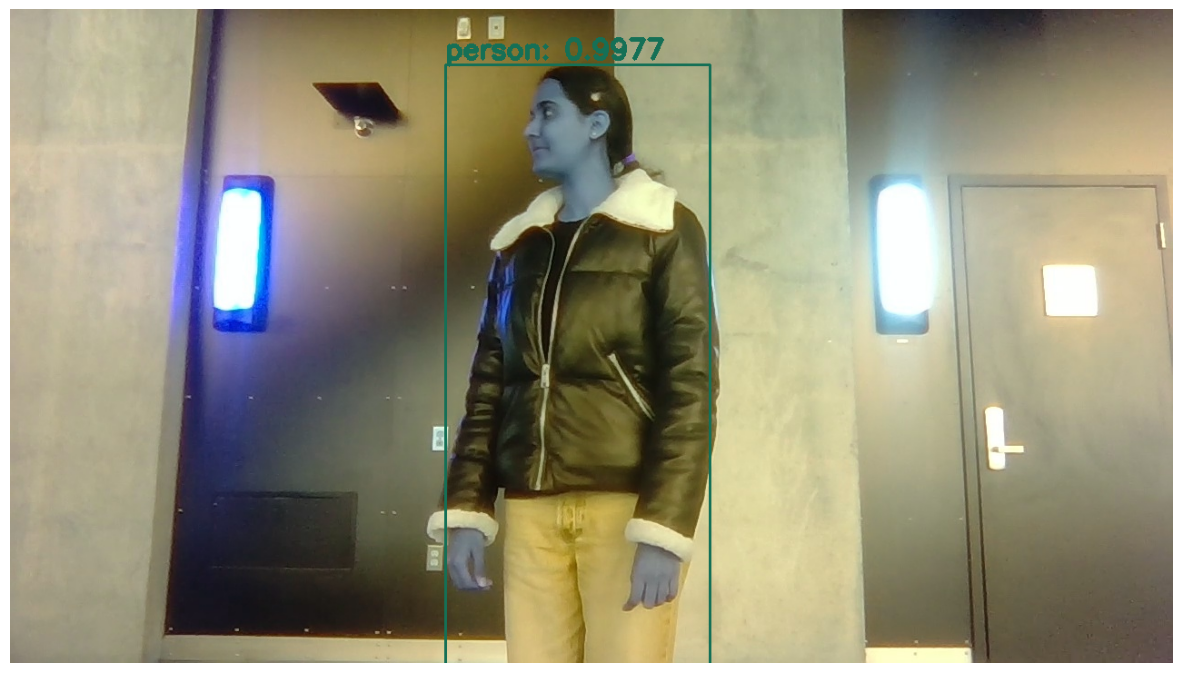

In [49]:
img0 = cv2.imread("output_frames/frame_127.jpg")
output_image = run_model(img0)

%matplotlib inline
plt.figure(figsize = (15,15))
plt.axis('off')
plt.imshow(output_image)

In [52]:
import cv2
import dlib
for i in labels2:
  if(i == "person" or i == "violation" ) :
    if ("violation" >= "0.7"):

      def face_verification(image_path_1, image_path_2):
          # Load pre-trained face detector from dlib
          face_detector = dlib.get_frontal_face_detector()

          # Load images
          image_1 = cv2.imread(image_path_1)
          image_2 = cv2.imread(image_path_2)

          # Convert images to grayscale
          gray_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
          gray_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

          # Detect faces in the images
          faces_1 = face_detector(gray_1)
          faces_2 = face_detector(gray_2)

          if len(faces_1) == 0 or len(faces_2) == 0:
              return

          # Get the first face in each image
          face_1 = faces_1[0]
          face_2 = faces_2[0]

          # Extract face embeddings using a face recognition model (e.g., FaceNet)
          # You need to implement this part or use a pre-trained model

          # Compare the embeddings for verification
          # You need to implement this part based on the face recognition model

          # For simplicity, let's assume faces are verified if they are in the same location
          verification_threshold = 550
          distance = dlib.rectangle.left(face_1) - dlib.rectangle.left(face_2)

          if abs(distance) < verification_threshold:
              name = os.path.splitext(os.path.basename(image_path_2))[0]
              print("Faces are verified in Database. Fine Generated. Notification sent to :", name)
              return True
          else:
              print("Faces are not verified. Checking Database again.")
              return False

      # Example usage
      image_path_1 = "output_frames/frame_127.jpg"
      dataset = "/dataset_folder"
      for filename in os.listdir(dataset):
        if filename.endswith(".jpg"):
          image_path_2 = os.path.join(dataset, filename)
          result = face_verification(image_path_1, image_path_2)

Faces are verified in Database. Fine Generated. Notification sent to : Foram


In [53]:
import cv2
import random

def capture_random_frames(video_path, output_folder, num_frames):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        print("Error: Unable to read video.")
        return

    print(f"Total frames in the video: {total_frames}")

    # Ensure the output folder exists
    import os
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Calculate random frame indices
    random_frames = random.sample(range(total_frames), num_frames)

    for frame_number in random_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if ret:
            output_path = os.path.join(output_folder, f"frame_{frame_number}.jpg")
            cv2.imwrite(output_path, frame)
            print(f"Saved frame {frame_number} at {output_path}")

    cap.release()

if __name__ == "__main__":
    # Replace 'input_video.mp4' with the path to your video file
    input_video_path = '/bike-front-view.mp4'

    # Replace 'output_frames' with the folder where you want to save the frames
    output_frames_folder = 'output_frames'

    # Specify the number of random frames you want to capture
    num_random_frames = 5

    capture_random_frames(input_video_path, output_frames_folder, num_random_frames)


Total frames in the video: 216
Saved frame 146 at output_frames/frame_146.jpg
Saved frame 163 at output_frames/frame_163.jpg
Saved frame 179 at output_frames/frame_179.jpg
Saved frame 41 at output_frames/frame_41.jpg
Saved frame 149 at output_frames/frame_149.jpg


Confidence Score: 0.0
Confidence : [0.9933881759643555, 0.9964705109596252, 0.9914441704750061, 0.9660032987594604]
For Helmet at  523 117 Bike is  486 486


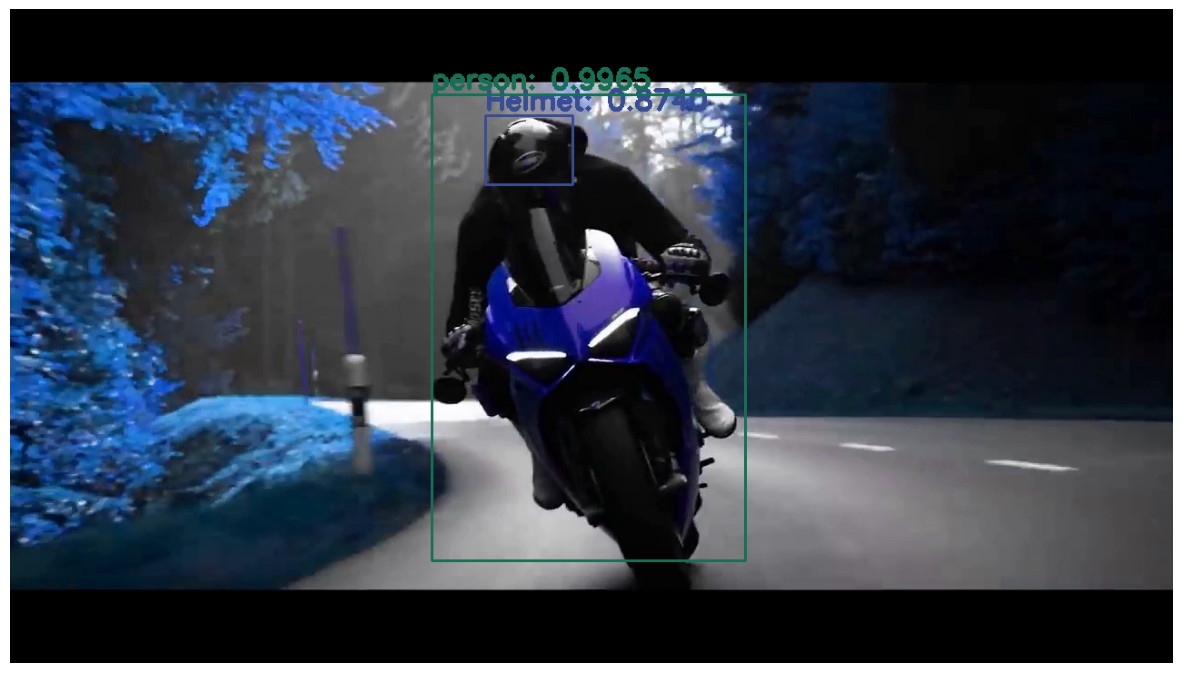

In [55]:
img0 = cv2.imread("output_frames/frame_41.jpg")
output_image = run_model(img0)

%matplotlib inline
plt.figure(figsize = (15,15))
plt.axis('off')
plt.imshow(output_image)

In [56]:
import cv2
import random

def capture_random_frames(video_path, output_folder, num_frames):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        print("Error: Unable to read video.")
        return

    print(f"Total frames in the video: {total_frames}")

    # Ensure the output folder exists
    import os
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Calculate random frame indices
    random_frames = random.sample(range(total_frames), num_frames)

    for frame_number in random_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if ret:
            output_path = os.path.join(output_folder, f"frame_{frame_number}.jpg")
            cv2.imwrite(output_path, frame)
            print(f"Saved frame {frame_number} at {output_path}")

    cap.release()

if __name__ == "__main__":
    # Replace 'input_video.mp4' with the path to your video file
    input_video_path = '/bike-test.mp4'

    # Replace 'output_frames' with the folder where you want to save the frames
    output_frames_folder = 'output_frames'

    # Specify the number of random frames you want to capture
    num_random_frames = 5

    capture_random_frames(input_video_path, output_frames_folder, num_random_frames)


Total frames in the video: 253
Saved frame 21 at output_frames/frame_21.jpg
Saved frame 77 at output_frames/frame_77.jpg
Saved frame 140 at output_frames/frame_140.jpg
Saved frame 220 at output_frames/frame_220.jpg
Saved frame 33 at output_frames/frame_33.jpg


Confidence Score: 0.0
Confidence : [0.9973343014717102, 0.9950106739997864, 0.9846786856651306, 0.8181561827659607, 0.9945117831230164, 0.9633017778396606, 0.9189239740371704, 0.8980910778045654, 0.5276437997817993, 0.5456891655921936, 0.8850349187850952, 0.9520326852798462, 0.7231305241584778, 0.8147570490837097, 0.9284049868583679, 0.7707913517951965, 0.9542868733406067, 0.5908558964729309, 0.692051887512207, 0.7862772345542908, 0.5080580711364746, 0.8229845762252808, 0.5947631597518921, 0.8502776622772217, 0.7634111642837524, 0.9092990159988403]
For Helmet at  60 197 Bike is  362 362
For Helmet at  385 244 Bike is  362 362
For Helmet at  249 247 Bike is  362 362
For Helmet at  535 230 Bike is  530 530


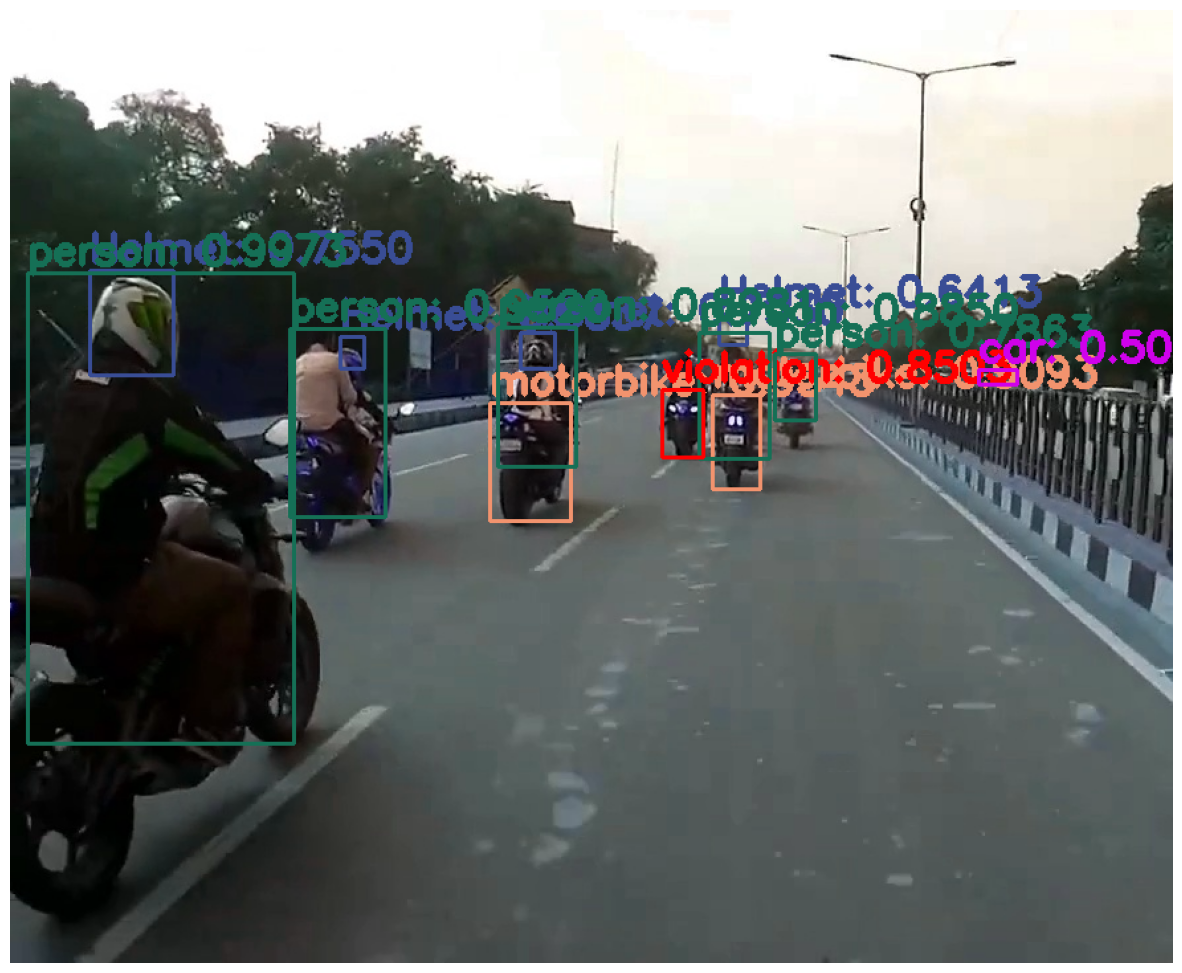

In [57]:
img0 = cv2.imread("output_frames/frame_140.jpg")
output_image = run_model(img0)

%matplotlib inline
plt.figure(figsize = (15,15))
plt.axis('off')
plt.imshow(output_image)

Confidence Score: 0.0
Confidence : [0.8998092412948608, 0.5645214915275574, 0.9994008541107178, 0.9664202332496643, 0.7613040208816528, 0.9050909876823425, 0.9628660678863525, 0.9902040362358093, 0.998532235622406, 0.6051258444786072, 0.7949353456497192, 0.9920669794082642, 0.5340354442596436, 0.725424587726593]
For Helmet at  404 176 Bike is  3 3


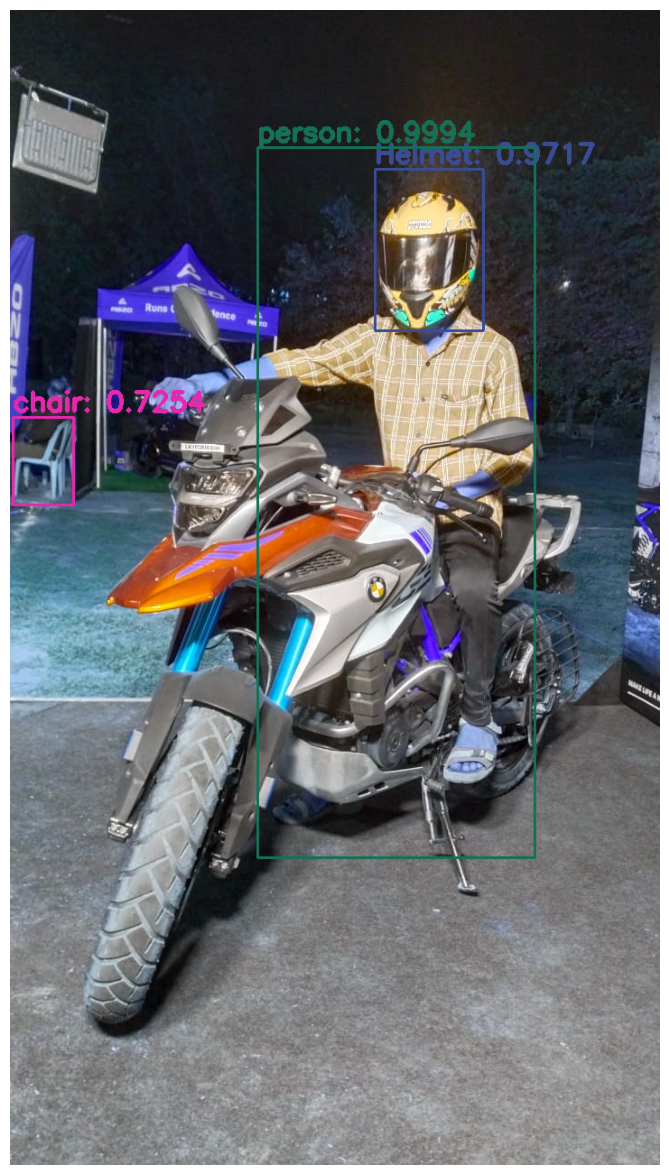

In [58]:
img0 = cv2.imread("/IMG-20240308-WA0001.jpg")
output_image = run_model(img0)

%matplotlib inline
plt.figure(figsize = (15,15))
plt.axis('off')
plt.imshow(output_image)